In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils.extmath import softmax

In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2784350209648356002,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10990990132
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3239920763073249717
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [5]:
from PIL import Image
import numpy as np

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save( outfilename )

In [6]:
train_size = 20000 #20000 #
test_size=1000
train_path = '../train/'
num_trainfiles = int(train_size/2)
num_testfiles = int(test_size/2)
train_filenames = [train_path+'/cat.%d.jpg' %i for i in range(1,num_trainfiles)]
train_filenames.extend([train_path+'/dog.%d.jpg' %i for i in range(1,num_trainfiles)])

In [7]:
test_filenames = [train_path+'/cat.%d.jpg' %i for i in range(num_trainfiles, num_trainfiles+num_testfiles)]
test_filenames.extend([train_path+'/dog.%d.jpg' %i for i in range(num_trainfiles, num_trainfiles+num_testfiles)])

In [8]:
INITIAL_LEARNING_RATE=0.0001
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = len(train_filenames)
MOVING_AVERAGE_DECAY = 0.9999     # The decay to use for the moving average.
batch_size=32
NUM_EPOCHS_PER_DECAY = 10
LEARNING_RATE_DECAY_FACTOR = 0.88
num_batches_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN / batch_size
decay_steps = int(num_batches_per_epoch * NUM_EPOCHS_PER_DECAY)
IM_HEIGHT=128 #256
IM_WIDTH=128 #256
NUM_CLASSES=2

In [9]:
data = load_image(train_path+'/cat.10.jpg')
#for i range(12500)

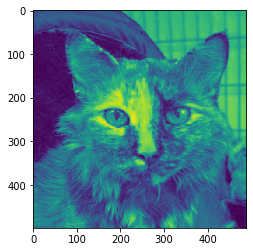

In [10]:
plt.imshow(data[:,:,2])

In [11]:
from PIL import Image
imdata = Image.open(train_path+'/cat.10.jpg')
imdata.resize((256,256), resample=Image.BICUBIC)
imdata.load()
data = np.asarray( imdata, dtype="int32" )

In [12]:
imagesData = np.zeros((len(train_filenames), IM_WIDTH, IM_HEIGHT, 1), dtype="float32")
for idx,fn in enumerate(train_filenames):
    imdata = Image.open(fn)
    imdata = imdata.resize((IM_WIDTH,IM_HEIGHT), resample=Image.BICUBIC)
    imdata.load()
    data = np.asarray(imdata, dtype="float32")
    imagesData[idx,:,:,0] = data[:,:,1]
    if (idx%1000)==0:
        print("loaded ",idx)

loaded  0
loaded  1000
loaded  2000
loaded  3000
loaded  4000
loaded  5000
loaded  6000
loaded  7000
loaded  8000
loaded  9000
loaded  10000
loaded  11000
loaded  12000
loaded  13000
loaded  14000
loaded  15000
loaded  16000
loaded  17000
loaded  18000
loaded  19000


In [17]:
import sys
sys.getsizeof(imagesData)/1000000000

1.310589072

In [18]:
imagesLabel = np.zeros((len(train_filenames),2))
imagesLabel[:num_trainfiles-1,1] = 1
imagesLabel[num_trainfiles-1:,0] = 1

In [19]:
testImagesData = np.zeros((len(test_filenames), IM_WIDTH, IM_HEIGHT, 1), dtype="float32")
for idx,fn in enumerate(test_filenames):
    testimdata = Image.open(fn)
    testimdata = testimdata.resize((IM_WIDTH,IM_HEIGHT), resample=Image.BICUBIC)
    testimdata.load()
    data = np.asarray(testimdata, dtype="float32")
    testImagesData[idx,:,:,0] = data[:,:,1]
    if (idx%100)==0:
        print("loaded ",idx)

loaded  0
loaded  100
loaded  200
loaded  300
loaded  400
loaded  500
loaded  600
loaded  700
loaded  800
loaded  900


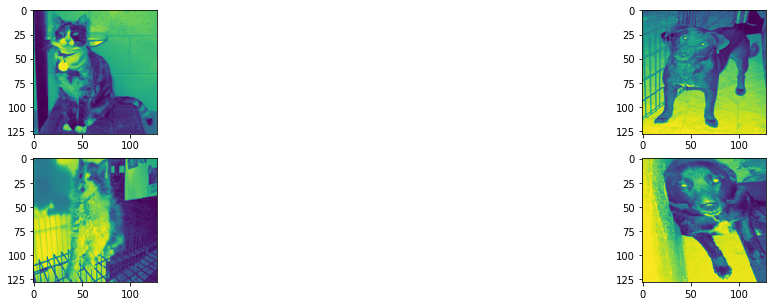

In [20]:
plt.figure(figsize=(20,5))
plt.subplot(2,2,1)
_=plt.imshow(imagesData[num_trainfiles-2,:,:,0])
plt.subplot(2,2,2)
_=plt.imshow(imagesData[num_trainfiles-1,:,:,0])
plt.subplot(2,2,3)
_=plt.imshow(testImagesData[num_testfiles-1,:,:,0])
plt.subplot(2,2,4)
_=plt.imshow(testImagesData[num_testfiles,:,:,0])

In [21]:
len(testImagesData), num_testfiles

(1000, 500)

In [22]:
testImagesLabel = np.zeros((len(test_filenames),2))
testImagesLabel[:num_testfiles,1] = 1
testImagesLabel[num_testfiles:,0] = 1

In [23]:
imagesLabel.shape

(19998, 2)

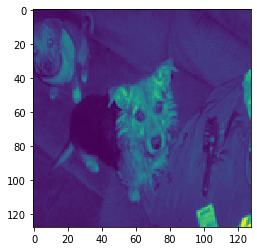

In [24]:
plt.imshow(data[:,:,1])

In [ ]:
def train_network(total_loss, global_step):
    """Train CIFAR-10 model.
      Create an optimizer and apply to all trainable variables. Add moving
      average for all trainable variables.
      Args:
        total_loss: Total loss from loss().
        global_step: Integer Variable counting the number of training steps
          processed.
      Returns:
        train_op: op for training.
      """
    # Variables that affect learning rate.
    num_batches_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN / FLAGS.batch_size
    decay_steps = int(num_batches_per_epoch * NUM_EPOCHS_PER_DECAY)

    # Decay the learning rate exponentially based on the number of steps.
    lr = tf.train.exponential_decay(INITIAL_LEARNING_RATE,
                                      global_step,
                                      decay_steps,
                                      LEARNING_RATE_DECAY_FACTOR,
                                      staircase=True)
    tf.summary.scalar('learning_rate', lr)

    # Generate moving averages of all losses and associated summaries.
    #loss_averages_op = _add_loss_summaries(total_loss)

    # Compute gradients.
    #with tf.control_dependencies([loss_averages_op]):
    #    opt = tf.train.GradientDescentOptimizer(lr)
    #    grads = opt.compute_gradients(total_loss)

    opt = tf.train.GradientDescentOptimizer(lr)
    grads = opt.compute_gradients(total_loss)
    # Apply gradients.
    apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)

    # Add histograms for trainable variables.
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)

    # Add histograms for gradients.
    for grad, var in grads:
        if grad is not None:
            tf.summary.histogram(var.op.name + '/gradients', grad)

    # Track the moving averages of all trainable variables.
    variable_averages = tf.train.ExponentialMovingAverage(
        MOVING_AVERAGE_DECAY, global_step)
    variables_averages_op = variable_averages.apply(tf.trainable_variables())

    with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
        train_op = tf.no_op(name='train')

    return train_op


In [25]:
if ('sess' in vars()) or ('sess' in globals()):
    sess.close()
    print('Previous Session Closed...')
from tensorflow.python.framework import ops
tf.compat.v1.reset_default_graph()
ops.reset_default_graph()
images = tf.placeholder(tf.float32, shape=[None, IM_WIDTH, IM_HEIGHT, 1])
labels = tf.placeholder(tf.float32, [None, NUM_CLASSES])

In [26]:
images.get_shape()[1]

Dimension(128)

In [ ]:
def _add_to_losses(weight_var, wd):    
    weight_decay = tf.multiply(tf.nn.l2_loss(weight_var), wd, name='weight_loss')
    tf.add_to_collection('losses', weight_decay)

In [ ]:
def loss(labels, logits):
    #labels = tf.cast(labels, tf.float16)
    #cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, \
    #                                                               logits=logits, \
    #                                                               name='cross_entropy_per_example')
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels, \
                                                            logits=logits, \
                                                            name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    tf.add_to_collection('losses', cross_entropy_mean)

    # The total loss is defined as the cross entropy loss plus all of the weight
    # decay terms (L2 loss).
    lossval = tf.add_n(tf.get_collection('losses'), name='total_loss')
    return lossval

In [95]:
def inference_model_old(images):
    #kernel = _variable_with_weight_decay('weights',shape=[5, 5, 3, 64],stddev=5e-2,wd=None)
    dtype=tf.float32
    stddev=5e-2
    with tf.device('/device:GPU:0'):
        with tf.variable_scope('conv1', reuse=tf.AUTO_REUSE) as scope: #[5, 5, 3, 64],
            kernel = tf.get_variable('weights', [5, 5, 1, 32], \
                                     initializer=tf.truncated_normal_initializer(stddev=stddev, dtype=dtype), \
                                     dtype=dtype)
            conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME') # [1, 1, 1, 1]
            #biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
            biases = tf.get_variable('biases', [32], initializer=tf.constant_initializer(0.0), dtype=dtype)
            pre_activation = tf.nn.bias_add(conv, biases)
            conv1 = tf.nn.relu(pre_activation, name=scope.name)
            #_activation_summary(conv1)

            #print(biases.shape, conv.shape)

        pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], #ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                             padding='SAME', name='pool1')

        #norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
        print("pool1:",biases.shape, conv1.shape, pool1.shape) #, norm1.shape)
        ##########################################################
        #kernel = _variable_with_weight_decay('weights',shape=[5, 5, 64, 64],stddev=5e-2,wd=None)
        with tf.variable_scope('conv2', reuse=tf.AUTO_REUSE) as scope: #[5, 5, 3, 64],
            kernel = tf.get_variable('weights', [5, 5, 32, 16], \
                                     initializer=tf.truncated_normal_initializer(stddev=stddev, dtype=dtype), \
                                     dtype=dtype)
            conv = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME') # norm1
            #biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.1))
            biases = tf.get_variable('biases', [16], initializer=tf.constant_initializer(0.0), dtype=dtype)
            pre_activation = tf.nn.bias_add(conv, biases)
            conv2 = tf.nn.relu(pre_activation, name=scope.name)
            #_activation_summary(conv2)


        #norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')

        pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],  #ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], 
                               padding='SAME', name='pool2') #norm2
        print("pool2:",biases.shape, conv2.shape, pool2.shape) #, norm2.shape,
        ##########################################################
        ##########################################################
        #kernel = _variable_with_weight_decay('weights',shape=[5, 5, 64, 64],stddev=5e-2,wd=None)
        with tf.variable_scope('conv3', reuse=tf.AUTO_REUSE) as scope: #[5, 5, 3, 64],
            kernel = tf.get_variable('weights', [3, 3, 16, 16], \
                                     initializer=tf.truncated_normal_initializer(stddev=stddev, dtype=dtype), \
                                     dtype=dtype)
            conv = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME') # norm1
            #biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.1))
            biases = tf.get_variable('biases', [16], initializer=tf.constant_initializer(0.0), dtype=dtype)
            pre_activation = tf.nn.bias_add(conv, biases)
            conv3 = tf.nn.relu(pre_activation, name=scope.name)
            #_activation_summary(conv2)


        #norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')

        pool3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],  
                               #ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], 
                               padding='SAME', name='pool3') #norm2
        print("pool3:",biases.shape, conv3.shape, pool3.shape) #, norm2.shape,
        ##########################################################
        #print(pool2.get_shape())
        with tf.variable_scope('local3', reuse=tf.AUTO_REUSE) as scope:
            # Move everything into depth so we can perform a single matrix multiply.
            reshape = tf.reshape(pool3, shape=[tf.shape(images)[0], -1]) 
            #[images.get_shape().as_list()[0], -1])
            #print(reshape.shape)
            #dim = reshape.get_shape()[1] #tf.shape(reshape)[1].value #256*64 #reshape.get_shape()[1].value #
            dim = 16*16*16
            weights = tf.get_variable('weights', [dim, 1024], \
                                      initializer=tf.truncated_normal_initializer(stddev=0.04, dtype=dtype), \
                                      dtype=dtype)
            #_add_to_losses(weights, 0.004)
            #weights = _variable_with_weight_decay('weights', shape=[dim, 384], stddev=0.04, wd=0.004)
            biases = tf.get_variable('biases', [1024], initializer=tf.constant_initializer(0.1), dtype=dtype)
            #biases = _variable_on_cpu('biases', [384], tf.constant_initializer(0.1))
            local3 = tf.nn.relu(tf.nn.bias_add(tf.matmul(reshape, weights), biases), name=scope.name)

            print("local3:",weights.shape, local3.shape)
        # local4
        ##########################################################
        with tf.variable_scope('local4', reuse=tf.AUTO_REUSE) as scope:
            weights = tf.get_variable('weights', [1024, 512], \
                                      initializer=tf.truncated_normal_initializer(stddev=0.04, dtype=dtype), \
                                      dtype=dtype)
            #_add_to_losses(weights, 0.004)
            #weights = _variable_with_weight_decay('weights', shape=[384, 192],stddev=0.04, wd=0.004)
            biases = tf.get_variable('biases', [512], initializer=tf.constant_initializer(0.1), dtype=dtype)
            #biases = _variable_on_cpu('biases', [192], tf.constant_initializer(0.1))
            local4 = tf.nn.relu(tf.nn.bias_add(tf.matmul(local3, weights), biases), name=scope.name)
            print("local4:",weights.shape, local4.shape)
        ##########################################################
        with tf.variable_scope('softmax_linear', reuse=tf.AUTO_REUSE) as scope:
            weights = tf.get_variable('weights', [512, NUM_CLASSES], \
                                      initializer=tf.truncated_normal_initializer(stddev=1/192.0, dtype=dtype), \
                                      dtype=dtype)
            #weights = _variable_with_weight_decay('weights', [192, NUM_CLASSES], stddev=1/192.0, wd=None)
            biases = tf.get_variable('biases', [NUM_CLASSES], initializer=tf.constant_initializer(0.0), dtype=dtype)
            #biases = _variable_on_cpu('biases', [NUM_CLASSES],tf.constant_initializer(0.0))
            softmlin = tf.identity(tf.nn.softmax(tf.nn.bias_add(tf.matmul(local4, weights), biases)), name=scope.name)
            
            print("softmax_linear:",weights.shape, biases.shape, softmlin.shape)

    #print(softmax_linear.shape, local4.shape)
    return softmlin #tf.nn.softmax(softmlin)

In [27]:
class vinnet():
    def __init__(self):
        self.dtype=tf.float32
        self.stddev=5e-2
    def inference_model(self, images):
        with tf.device('/device:GPU:0'):
            with tf.variable_scope('conv1', reuse=tf.AUTO_REUSE) as scope:
                conv11 = self.add_conv2d(scope, intensor= images, kershape=[5,5,1,32], stride=[1,1,1,1], \
                                        name='conv11', activation=tf.nn.relu)
                conv12 = self.add_conv2d(scope, intensor= conv11, kershape=[5,5,32,32], stride=[1,1,1,1], \
                                        name='conv12', activation=tf.nn.tanh)
                conv13 = self.add_conv2d(scope, intensor= conv12, kershape=[3,3,32,32], stride=[1,1,1,1], \
                                        name='conv13', activation=tf.nn.tanh)
                pool1 = self.add_pool(scope, intensor=conv13, poolshape=[1,2,2,1], stride=[1,2,2,1], \
                                      name='pool11')
            with tf.variable_scope('conv2', reuse=tf.AUTO_REUSE) as scope:
                conv21 = self.add_conv2d(scope, intensor= pool1, kershape=[3,3,32,32], stride=[1,1,1,1], \
                                        name='conv21', activation=tf.nn.relu)
                conv22 = self.add_conv2d(scope, intensor= conv21, kershape=[3,3,32,32], stride=[1,1,1,1], \
                                        name='conv22', activation=tf.nn.tanh)
                res2 = tf.add(conv22, pool1, name='res2')
                pool2 = self.add_pool(scope, intensor=res2, poolshape=[1,2,2,1], stride=[1,2,2,1], \
                                      name='pool21')
            with tf.variable_scope('conv3', reuse=tf.AUTO_REUSE) as scope:
                conv31 = self.add_conv2d(scope, intensor= pool2, kershape=[3,3,32,48], stride=[1,1,1,1], \
                                        name='conv31', activation=tf.nn.tanh)
                conv32 = self.add_conv2d(scope, intensor= conv31, kershape=[3,3,48,32], stride=[1,1,1,1], \
                                        name='conv32', activation=tf.nn.relu)
                #res2 = tf.add(conv22, pool1, name='res2')
                pool3 = self.add_pool(scope, intensor=conv32, poolshape=[1,2,2,1], stride=[1,2,2,1], \
                                      name='pool31')
            with tf.variable_scope('conv4', reuse=tf.AUTO_REUSE) as scope:
                conv41 = self.add_conv2d(scope, intensor= pool3, kershape=[3,3,32,16], stride=[1,1,1,1], \
                                        name='conv41', activation=tf.nn.relu)
                conv42 = self.add_conv2d(scope, intensor= conv41, kershape=[3,3,16,16], stride=[1,1,1,1], \
                                        name='conv42', activation=tf.nn.tanh)
                pool4 = self.add_pool(scope, intensor=conv42, poolshape=[1,2,2,1], stride=[1,2,2,1], \
                                      name='pool41')
            with tf.variable_scope('local3', reuse=tf.AUTO_REUSE) as scope:
                local3 = self.add_fc(scope, intensor=pool4, flatten=True, outshape=1024, name='local3',\
                                    activation=tf.nn.relu)
            with tf.variable_scope('local4', reuse=tf.AUTO_REUSE) as scope:
                local4 = self.add_fc(scope, intensor=local3, flatten=False, outshape=512, name='local4',\
                                    activation=tf.nn.relu)
            with tf.variable_scope('softmax_linear', reuse=tf.AUTO_REUSE) as scope:
                softmaxlin = self.add_fc(scope, intensor=local4, flatten=False, outshape=NUM_CLASSES, \
                                         name='softmaxlin', activation=None)     
        return softmaxlin
                
    def add_fc(self, scope, intensor=None, flatten=False, outshape=1, name='localfc', activation=None):
        stddev=self.stddev
        dtype=self.dtype
        inshape = intensor.get_shape().as_list()
        dim = 1
        for d in inshape[1:]:
            dim *= d #intensor.shape[1]*intensor.shape[2]*intensor.shape[3]
        if flatten==True:
            reshaped = tf.reshape(intensor, shape=[-1, dim])
        else:
            reshaped=intensor
        weights = tf.get_variable('weights', [dim, outshape], \
                                  initializer=tf.truncated_normal_initializer(stddev=0.04, dtype=dtype), \
                                  dtype=dtype)
        biases = tf.get_variable('biases', [outshape], initializer=tf.constant_initializer(0.1), dtype=dtype)
        
        if (activation is None):
            activation=tf.identity
        
        localfc = activation(tf.nn.bias_add(tf.matmul(reshaped, weights), biases), name=scope.name)
        print(name,weights.shape, localfc.shape)
        return localfc
    def add_conv2d(self, scope, intensor=None,kershape=[5,5,1,32], stride=[1,1,1,1], name='conv', \
                   activation=tf.nn.relu):
        stddev=self.stddev
        dtype=self.dtype
        kernel = tf.get_variable('w_'+name, kershape, \
                             initializer=tf.truncated_normal_initializer(stddev=stddev, dtype=dtype), \
                             dtype=dtype)
        conv = tf.nn.conv2d(intensor, kernel, stride, padding='SAME') # [1, 1, 1, 1]
        biases = tf.get_variable('b_'+name, kershape[3], initializer=tf.constant_initializer(0.0), dtype=dtype)
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = activation(pre_activation, name=scope.name)
        print(name, biases.shape, conv1.shape)
        return conv1
    def add_pool(self, scope, intensor=None, poolshape=[1,2,2,1], stride=[1,2,2,1],name='pool'):
        stddev=self.stddev
        dtype=self.dtype
        pool1 = tf.nn.max_pool(intensor, ksize=poolshape, strides=stride, padding='SAME', name=name)
        print(name, pool1.shape)
        return pool1


In [28]:
vnet = vinnet()
global_step = tf.train.get_or_create_global_step()
logits = vnet.inference_model(images) #inference_model_old(images)
print("logits", logits.shape, labels.shape)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, \
                                                            logits=logits, \
                                                            name='cross_entropy_per_example')
cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
tf.add_to_collection('losses', cross_entropy_mean)

# The total loss is defined as the cross entropy loss plus all of the weight
# decay terms (L2 loss).
lossval = tf.add_n(tf.get_collection('losses'), name='total_loss')
acc_op = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(labels, 1), tf.argmax(tf.nn.softmax(logits),1)), tf.float32))

#lossval = loss(logits, labels)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
conv11 (32,) (?, 128, 128, 32)
conv12 (32,) (?, 128, 128, 32)
conv13 (32,) (?, 128, 128, 32)
pool11 (?, 64, 64, 32)
conv21 (32,) (?, 64, 64, 32)
conv22 (32,) (?, 64, 64, 32)
pool21 (?, 32, 32, 32)
conv31 (48,) (?, 32, 32, 48)
conv32 (32,) (?, 32, 32, 32)
pool31 (?, 16, 16, 32)
conv41 (16,) (?, 16, 16, 16)
conv42 (16,) (?, 16, 16, 16)
pool41 (?, 8, 8, 16)
local3 (1024, 1024) (?, 1024)
local4 (1024, 512) (?, 512)
softmaxlin (512, 2) (?, 2)
logits (?, 2) (?, 2)


In [ ]:
#with tf.Graph().as_default():

#define losses
# Decay the learning rate exponentially based on the number of steps.
lr = tf.train.exponential_decay(INITIAL_LEARNING_RATE,
                                      global_step,
                                      decay_steps,
                                      LEARNING_RATE_DECAY_FACTOR,
                                      staircase=True)
tf.summary.scalar('learning_rate', lr)

In [29]:
lr = tf.train.exponential_decay(INITIAL_LEARNING_RATE,
                                      global_step,
                                      decay_steps,
                                      LEARNING_RATE_DECAY_FACTOR,
                                      staircase=True)

In [30]:
opt = tf.train.AdamOptimizer(lr) #(1e-5)
grads_and_vars = opt.compute_gradients(cross_entropy)
apply_gradient_op = opt.apply_gradients(grads_and_vars, global_step=global_step)

In [35]:
sess.close()
init = tf.global_variables_initializer()
sess   = tf.Session()
sess.run(init)
v = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='softmax_linear')
v0 = sess.run(v[0])
v1 = sess.run(v[1])
sess.close()

In [36]:
print(v0,v1, v0.shape, v1.shape)

[[ 1.2449581e-03 -9.9740401e-03]
 [-6.1994913e-04  4.5714411e-03]
 [-9.2328545e-03 -5.2169575e-03]
 [-6.7065707e-03 -2.9100641e-03]
 [-4.9780868e-03 -7.4512605e-04]
 [-2.9224419e-04  1.6010891e-03]
 [-8.0847219e-03  3.7412168e-03]
 [-5.4179225e-04  3.2806732e-03]
 [ 3.1688937e-03  1.2334746e-03]
 [ 2.7462102e-03  5.3807171e-03]
 [-4.5431973e-03  1.6612689e-03]
 [ 1.1596184e-04  1.8747780e-03]
 [-7.5683650e-04 -4.6060970e-03]
 [-6.8915593e-03  2.9805133e-03]
 [ 4.1017476e-03  5.0108149e-03]
 [ 8.3147623e-03  7.2701117e-03]
 [ 6.1310343e-03 -4.8598628e-03]
 [-3.5292117e-04  2.1498438e-04]
 [ 7.5619398e-03  2.6908154e-03]
 [-3.2658671e-04 -6.2247701e-03]
 [ 3.0783077e-03 -3.0793499e-03]
 [-5.5449931e-03  5.7453541e-03]
 [ 7.7533349e-03 -1.0156557e-02]
 [ 3.5334774e-03 -7.4008862e-03]
 [-3.7185336e-03 -6.0961656e-03]
 [ 5.6449184e-03 -7.8149035e-04]
 [ 8.8925231e-03 -2.0242296e-03]
 [-3.9714845e-03 -3.5698474e-03]
 [ 9.9086319e-04  2.5112610e-03]
 [ 4.3051253e-04  4.1356846e-03]
 [ 4.26124

In [55]:
#sess.close()
#sess = tf.Session()
op = sess.graph.get_operations()
for m in op:
    print(m.values())
#sess.close()

(<tf.Tensor 'Placeholder:0' shape=(?, 128, 128, 1) dtype=float32>,)
(<tf.Tensor 'Placeholder_1:0' shape=(?, 2) dtype=float32>,)
(<tf.Tensor 'global_step/Initializer/zeros/shape_as_tensor:0' shape=(0,) dtype=int32>,)
(<tf.Tensor 'global_step/Initializer/zeros/Const:0' shape=() dtype=int64>,)
(<tf.Tensor 'global_step/Initializer/zeros:0' shape=() dtype=int64>,)
(<tf.Tensor 'global_step:0' shape=() dtype=int64_ref>,)
(<tf.Tensor 'global_step/Assign:0' shape=() dtype=int64_ref>,)
(<tf.Tensor 'global_step/read:0' shape=() dtype=int64>,)
(<tf.Tensor 'conv1/w_conv11/Initializer/truncated_normal/shape:0' shape=(4,) dtype=int32>,)
(<tf.Tensor 'conv1/w_conv11/Initializer/truncated_normal/mean:0' shape=() dtype=float32>,)
(<tf.Tensor 'conv1/w_conv11/Initializer/truncated_normal/stddev:0' shape=() dtype=float32>,)
(<tf.Tensor 'conv1/w_conv11/Initializer/truncated_normal/TruncatedNormal:0' shape=(5, 5, 1, 32) dtype=float32>,)
(<tf.Tensor 'conv1/w_conv11/Initializer/truncated_normal/mul:0' shape=(5,

In [397]:
sess.close()
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [57]:
p1 = tf.get_default_graph().get_tensor_by_name('conv1/pool11:0')
p2 = tf.get_default_graph().get_tensor_by_name('conv2/pool21:0')
l4 = tf.get_default_graph().get_tensor_by_name('local4/local4:0')
sl4 = tf.get_default_graph().get_tensor_by_name('softmax_linear/softmax_linear:0')
b5 = tf.get_default_graph().get_tensor_by_name('softmax_linear/biases:0')
w5 = tf.get_default_graph().get_tensor_by_name('softmax_linear/weights:0')

In [58]:
p1val, p2val, sl4val, l4val, logitvals, gradvals_1, gradvals_2, w5vals, b5vals = \
                sess.run([p1,p2, sl4,l4,logits, grads_and_vars[-1], grads_and_vars[-2], w5,b5], \
                                                            feed_dict={images:image_data, labels: label_data})

In [116]:
sess.close()

In [60]:
logitvals, sl4val

(array([[ -8.401566 ,   7.301737 ],
        [ 23.622986 , -24.146505 ],
        [ 16.217588 , -17.230768 ],
        [ -8.439191 ,   7.3602476],
        [ 17.67423  , -18.678862 ],
        [-26.819094 ,  25.279924 ],
        [-16.854721 ,  15.919764 ],
        [ 14.318311 , -14.968958 ],
        [-21.089046 ,  19.956287 ],
        [ 27.365015 , -29.111103 ],
        [ 10.773167 , -11.770744 ],
        [-24.87012  ,  23.33994  ],
        [-12.235732 ,  12.481165 ],
        [ -8.807571 ,   7.5875225],
        [ 12.788927 , -14.718292 ],
        [-11.87688  ,  11.208269 ],
        [ 10.647731 , -10.710323 ],
        [-11.650676 ,  10.685764 ],
        [-17.598845 ,  16.590153 ],
        [ -8.888125 ,   7.9828467],
        [ -8.766034 ,   7.772553 ],
        [ 16.159319 , -17.262415 ],
        [ 10.029597 , -10.244039 ],
        [ 10.793335 , -11.6844845],
        [ 12.606526 , -13.278732 ],
        [ 17.713198 , -18.991394 ],
        [ 13.065087 , -13.682456 ],
        [-13.589673 ,  11.93

In [251]:
crossentropyvals, logitvals, label_data, softmax(logitvals), gradvals_2

(array([3.5389922 , 3.5389922 , 3.5389922 , 0.02947266, 0.02947266,
        0.02947266, 0.02947266, 3.5389922 , 3.5389922 , 3.5389922 ,
        0.02947266, 0.02947266, 0.02947266, 3.5389922 , 3.5389922 ,
        3.5389922 , 0.02947266, 0.02947266, 0.02947266, 0.02947266,
        0.02947266, 3.5389922 , 0.02947266, 0.02947266, 3.5389922 ,
        3.4843524 , 0.02947266, 0.02947266, 3.5389922 , 3.5389922 ,
        0.02947266, 0.02947266], dtype=float32),
 array([[ 1.7589849, -1.7505347],
        [ 1.7589849, -1.7505347],
        [ 1.7589849, -1.7505347],
        [ 1.7589849, -1.7505347],
        [ 1.7589849, -1.7505347],
        [ 1.7589849, -1.7505347],
        [ 1.7589849, -1.7505347],
        [ 1.7589849, -1.7505347],
        [ 1.7589849, -1.7505347],
        [ 1.7589849, -1.7505347],
        [ 1.7589849, -1.7505347],
        [ 1.7589849, -1.7505347],
        [ 1.7589849, -1.7505347],
        [ 1.7589849, -1.7505347],
        [ 1.7589849, -1.7505347],
        [ 1.7589849, -1.7505347],

In [248]:
_ = sess.run(apply_gradient_op, feed_dict={images: image_data, labels: label_data})

In [85]:
import autograd
from autograd import grad

In [166]:
def outlayer(bvals):
    #return np.matmul(l4val, w5vals)+bvals
    return (-1.*(np.log(softmax(np.matmul(l4val, w5vals)+bvals))*label_data))

In [167]:
testlogits = outlayer(b5vals)
print(testlogits)

[[0.         0.11531897]
 [0.         0.338799  ]
 [0.         0.29497778]
 [1.63337362 0.        ]
 [1.14196265 0.        ]
 [1.55233896 0.        ]
 [1.57005894 0.        ]
 [0.         0.24254042]
 [0.         0.33800313]
 [0.         0.3262631 ]
 [2.10536718 0.        ]
 [2.59275889 0.        ]
 [1.18435907 0.        ]
 [0.         0.24800567]
 [0.         0.23633589]
 [0.         0.39710879]
 [1.20412862 0.        ]
 [1.28202558 0.        ]
 [1.31004488 0.        ]
 [1.887995   0.        ]
 [1.60465074 0.        ]
 [0.         0.2107289 ]
 [1.32451749 0.        ]
 [1.25770438 0.        ]
 [0.         0.2659502 ]
 [0.         0.32295808]
 [1.76098907 0.        ]
 [1.32839918 0.        ]
 [0.         0.57594597]
 [0.         0.22878213]
 [1.63184369 0.        ]
 [1.2592715  0.        ]]


In [63]:
image_data.shape

(32, 128, 128, 1)

In [71]:
grads[-2]

(<tf.Tensor 'gradients/softmax_linear/MatMul_grad/tuple/control_dependency_1:0' shape=(192, 2) dtype=float32>,
 <tf.Variable 'softmax_linear/weights:0' shape=(192, 2) dtype=float32_ref>)

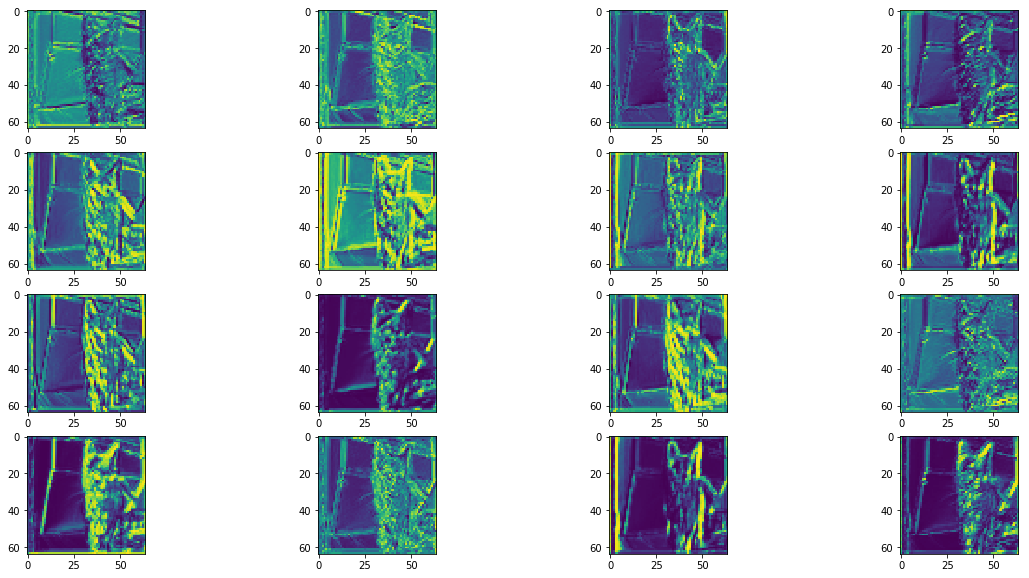

In [59]:
plt.figure(figsize=(20,10))
imid=12
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*i+j+1)
        _ = plt.imshow(p1val[imid,:,:,4*i+j])
#plt.subplot(3,1,2)
#_ = plt.imshow(p2val[imid,:,:,15])
#plt.subplot(3,1,3)
#_ = plt.imshow(image_data[imid,:,:,0])

In [142]:
np.max(l4val, 0), np.max(l4val)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.25261312e+08,
        5.00666099e+13, 0.00000000e+00, 0.00000000e+00, 6.02449408e+09,
        3.69496624e+13, 4.48465352e+14, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.24757699e+10,
        0.00000000e+00, 4.58234087e+13, 0.00000000e+00, 0.00000000e+00,
        1.48047462e+09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.38362296e+10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        9.87797389e+12, 8.59711078e+09, 1.42050654e+13, 0.00000000e+00,
        0.00000000e+00, 6.85523558e+09, 0.00000000e+00, 1.78282660e+10,
        0.00000000e+00, 2.90130342e+14, 0.00000000e+00, 0.00000000e+00,
        4.72784179e+09, 0.00000000e+00, 1.04554109e+12, 1.087494

In [136]:
print('l4val=\n',l4val, '\n sl4val=\n',sl4val, '\n logitvals=\n',logitvals, 
      '\n softmax=\n',softmax(sl4val), '\nlabels=\n', label_data)

l4val=
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 
 sl4val=
 [[ 3.0755343e+17 -3.0755134e+17]
 [ 1.8990263e+17 -1.8990133e+17]
 [ 3.2260248e+17 -3.2260029e+17]
 [ 2.5357349e+17 -2.5357174e+17]
 [ 2.5847312e+17 -2.5847136e+17]
 [ 1.5361624e+17 -1.5361517e+17]
 [ 2.4924010e+17 -2.4923840e+17]
 [ 2.6150919e+17 -2.6150740e+17]
 [ 2.9790305e+17 -2.9790103e+17]
 [ 3.2085261e+17 -3.2085041e+17]
 [ 2.9893100e+17 -2.9892893e+17]
 [ 2.6935260e+17 -2.6935075e+17]
 [ 2.3476680e+17 -2.3476520e+17]
 [ 3.3472254e+17 -3.3472027e+17]
 [ 1.6882183e+17 -1.6882070e+17]
 [ 2.4693313e+17 -2.4693145e+17]
 [ 3.9208887e+17 -3.9208619e+17]
 [ 2.6142865e+17 -2.6142686e+17]
 [ 2.2788595e+17 -2.2788438e+17]
 [ 2.8930666e+17 -2.8930470e+17]
 [ 2.3196694e+17 -2.3196534e+17]
 [ 4.0089421e+17 -4.0089146e+17]
 [ 2.5403512e+17 -2.5403337e+17]
 [ 2.1784607e+17 -2.1784457e+17]
 [ 2.8287404e+17 -2.8287211e+17]


In [217]:
np.matmul(l4val, v0) + v1

array([[22889.773, 40725.15 ],
       [18520.268, 34514.45 ],
       [19011.277, 36095.05 ],
       [19551.87 , 35113.344],
       [11610.65 , 21409.072],
       [16451.42 , 32120.47 ],
       [13017.908, 25812.172],
       [26263.34 , 47783.37 ],
       [20432.14 , 34399.234],
       [16793.812, 34229.62 ],
       [18166.123, 32205.045],
       [19180.168, 34414.824],
       [15816.815, 30723.871],
       [21144.107, 42348.086],
       [10735.864, 20335.426],
       [16544.32 , 31519.326],
       [25584.818, 46852.723],
       [14937.173, 27766.35 ],
       [19551.771, 35318.68 ],
       [14384.9  , 26906.686],
       [22242.088, 43535.535],
       [11539.895, 21134.242],
       [21480.84 , 40343.785],
       [12473.098, 24979.457],
       [13801.464, 28207.166],
       [20581.025, 37914.227],
       [13192.833, 27972.297],
       [16154.934, 33876.906],
       [25355.438, 45547.934],
       [24105.863, 44509.44 ],
       [18025.883, 34531.492],
       [15167.671, 26336.95 ]], dtype=f

In [73]:
sess.run(init)
v1 = sess.run(grads, feed_dict={images: image_data, labels: label_data})
v2 = sess.run(g, feed_dict={images: image_data, labels: label_data})

In [ ]:
# Add histograms for trainable variables.
for var in tf.trainable_variables():
    tf.summary.histogram(var.op.name, var)

# Add histograms for gradients.
for grad, var in grads:
    if grad is not None:
        tf.summary.histogram(var.op.name + '/gradients', grad)

# Track the moving averages of all trainable variables.
variable_averages = tf.train.ExponentialMovingAverage(
    MOVING_AVERAGE_DECAY, global_step)
variables_averages_op = variable_averages.apply(tf.trainable_variables())

with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
    train_op = tf.no_op(name='train')

In [41]:
testImagesData.shape

(2000, 128, 128, 1)

In [82]:
gsval= sess.run([global_step])
print(gsval)

[13046]


In [31]:
init = tf.global_variables_initializer()
num_epochs=45

#with tf.Session(config=tf.ConfigProto(allow_soft_placement=False, log_device_placement=True)) as sess:
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=False, log_device_placement=True))
sess.run(init) 

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1



In [32]:
print("Epoch \t,num batches \t avg loss \t, curr loss \t, accuracy \t, learning_rate")
##now test the model by running the inference on the test data...
validateSize=500
rand_indices = np.random.choice(np.arange(testImagesData.shape[0]), validateSize, replace=False)
validate_data = testImagesData[rand_indices, :, :, 0].reshape(-1, IM_HEIGHT,IM_WIDTH,1)
validate_label = testImagesLabel[rand_indices, :].reshape(-1,2)

for i in range(num_epochs):
    rand_indices = np.arange(len(train_filenames))
    np.random.shuffle(rand_indices)
    currloss=0
    avg_acc=0
    step=0
    for idx in range(0, len(rand_indices)-batch_size, batch_size):
        #if idx>1:
        #    break
        #print("idx=",idx)
        image_data = imagesData[rand_indices[idx:idx+batch_size], :, :, 0].reshape(batch_size, IM_HEIGHT,IM_WIDTH,1)
        label_data = imagesLabel[rand_indices[idx:idx+batch_size], :]

        _ = sess.run(apply_gradient_op, feed_dict={images: image_data, labels: label_data})
        currlossval, accopval = sess.run([lossval, acc_op], \
                                                 feed_dict={images: image_data, labels: label_data})
        currloss+=currlossval
        avg_acc += accopval
        step+=1

    avg_loss = currloss/step
    avg_acc = avg_acc/step
    if (i%3)==0:
        validate_inference, validate_loss, validate_accopval, lrval = sess.run([logits, lossval, acc_op, lr], \
                                                    feed_dict={images: validate_data, labels: validate_label})
        print(i, idx+1, avg_loss, currloss, avg_acc, accopval, validate_loss, validate_accopval, lrval)

##now test the model by running the inference on the test data...
testdata = testImagesData[:, :, :, 0].reshape(-1, IM_HEIGHT,IM_WIDTH,1)
testlabel = testImagesLabel[:, :].reshape(-1,2)
testinference, testloss, testaccopval = sess.run([logits, lossval, acc_op], \
                                                 feed_dict={images: testdata, labels: testlabel})
print("test loss=", testloss, testaccopval)

Epoch 	,num batches 	 avg loss 	, curr loss 	, accuracy 	, learning_rate
0 19937 0.6322932737664535 394.55100283026695 0.6312600160256411 0.625 0.5798448 0.684 1e-04
3 19937 0.48058467855056125 299.88483941555023 0.7723357371794872 0.78125 0.5123901 0.758 1e-04
6 19937 0.32868329666029567 205.0983771160245 0.8589242788461539 0.875 0.46548146 0.782 1e-04
9 19937 0.14360866972651237 89.61180990934372 0.9504206730769231 0.96875 0.49120155 0.828 1e-04
12 19937 0.022152830996977475 13.823366542113945 0.9979467147435898 1.0 0.68050903 0.792 8.8e-05
15 19937 0.007195182124772915 4.489793645858299 0.9996494391025641 1.0 0.84353244 0.81 8.8e-05
18 19937 0.0068688463656937345 4.28616013219289 0.9997495993589743 1.0 1.0695531 0.796 8.8e-05
21 19937 0.0021622339924282966 1.3492340112752572 0.9999499198717948 1.0 1.0207477 0.804 7.743999e-05
24 19937 0.0006999869033891698 0.43679182771484193 0.9999499198717948 1.0 1.0258006 0.826 7.743999e-05
27 19937 0.0014978810362115324 0.9346777665959962 0.9998

In [32]:
sess.close()

In [28]:
sum(testinference[:,0]), sum(testinference[:,1]), testinference, softmax(testinference), testlabel.shape

(120.07054344192147,
 512.7770129367709,
 array([[ -1.8863915,   2.1637678],
        [-11.979364 ,  12.442947 ],
        [ -5.953152 ,   6.5409465],
        ...,
        [ 17.426414 , -17.07518  ],
        [  8.189694 ,  -8.118318 ],
        [  2.9515562,  -2.5041547]], dtype=float32),
 array([[1.7121350e-02, 9.8287868e-01],
        [2.4747124e-11, 1.0000000e+00],
        [3.7486966e-06, 9.9999630e-01],
        ...,
        [1.0000000e+00, 1.0378818e-15],
        [9.9999988e-01, 8.2702826e-08],
        [9.9574631e-01, 4.2536678e-03]], dtype=float32),
 (1000, 2))

In [33]:
testlogits = softmax(testinference)

In [34]:
testlogits[:10], testlabel[:10]

(array([[1.9655019e-04, 9.9980348e-01],
        [3.0611984e-12, 1.0000000e+00],
        [3.8706547e-12, 1.0000000e+00],
        [3.3243489e-07, 9.9999964e-01],
        [3.0976120e-13, 1.0000000e+00],
        [6.8513573e-10, 1.0000000e+00],
        [1.3073698e-14, 1.0000000e+00],
        [4.0100462e-05, 9.9995995e-01],
        [9.9988985e-01, 1.1017989e-04],
        [1.0733701e-10, 1.0000000e+00]], dtype=float32),
 array([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]]))

[1.8228896e-13 1.0000000e+00]


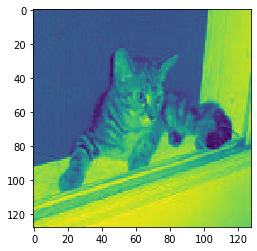

In [35]:
imid=28
plt.imshow(testdata[imid,:,:,0])
print(testlogits[imid,:])

In [32]:
logitvals = sess.run(logits, feed_dict={images:testdata[imid:imid+1,:,:,:]})

In [36]:
mod_image = testdata[imid,:,:,0]
#mod_image = testdata[imid,:,:,0] + 10*(np.random.rand(128,128)-0.5) #- 20*np.ones((128,128)) #

[[1.8228931e-13 1.0000000e+00]] [[-14.395945  14.937237]]


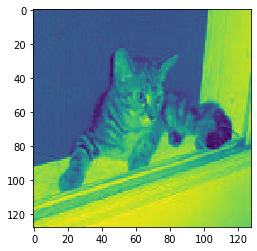

In [37]:
plt.imshow(mod_image)
mod_op = sess.run(logits, feed_dict={images:mod_image.reshape(-1,128,128,1)})
print(softmax(mod_op), mod_op)

In [38]:
orig_image = mod_image.reshape(-1,128,128,1)

In [41]:
logitvals[0]

array([-14.395124,  14.936345], dtype=float32)

In [51]:
orig_image.shape

(1, 128, 128, 1)

In [56]:
imid=2 #7
delta=10
orig_image = testdata[imid,:,:,0].reshape(-1,128, 128, 1)
orig_op = sess.run(logits, feed_dict={images:orig_image})
orig_logits = -np.log(softmax(orig_op))
inp_grad = np.zeros((128,128))
mod_image = np.copy(orig_image[0,:,:,0])
prev_x, prev_y=0,0
mod_image[prev_x,prev_y]+=delta
for px in range(128):
    for py in range(128):
        mod_image[prev_x,prev_y]-=delta
        mod_image[px,py]+=delta
        m1 = mod_image.reshape(-1,128, 128, 1)
        logitvals = sess.run(logits, feed_dict={images:m1})
        inp_grad[px,py] = -np.log(softmax(logitvals))[0][0] - orig_logits[0][0]
        prev_x,prev_y = px, py
    if (px%10)==0: print(px, end=' ')
print(inp_grad, np.sign(inp_grad))
mod_image = testdata[imid,:,:,0] - np.sign(inp_grad)
m1 = mod_image.reshape(-1,128,128,1)
mod_op = sess.run(logits, feed_dict={images:m1})
print(softmax(orig_op), softmax(mod_op))

0 10 20 30 40 50 60 70 80 90 100 110 120 [[ 0.00012589 -0.00759315 -0.02035141 ... -0.009758   -0.00322533
  -0.00491714]
 [ 0.00196457  0.00252533 -0.00769424 ... -0.00552368 -0.00964355
  -0.01534462]
 [ 0.00500488  0.00098419 -0.01080704 ... -0.02341461 -0.03855133
  -0.00879669]
 ...
 [ 0.01928711  0.02378464  0.00888443 ...  0.02726936 -0.00014114
  -0.0338974 ]
 [ 0.00301743  0.02493477  0.04448509 ...  0.01687813 -0.00422668
  -0.01847458]
 [ 0.01662064  0.01318741  0.03394127 ...  0.01770973  0.00754166
   0.00442123]] [[ 1. -1. -1. ... -1. -1. -1.]
 [ 1.  1. -1. ... -1. -1. -1.]
 [ 1.  1. -1. ... -1. -1. -1.]
 ...
 [ 1.  1.  1. ...  1. -1. -1.]
 [ 1.  1.  1. ...  1. -1. -1.]
 [ 1.  1.  1. ...  1.  1.  1.]]
[[3.8706473e-12 1.0000000e+00]] [[0.99706024 0.00293972]]


In [43]:
mod_image.shape, orig_image.shape
mod_image = np.copy(orig_image[0,:,:,0])

In [44]:
mod_image.shape

(128, 128)

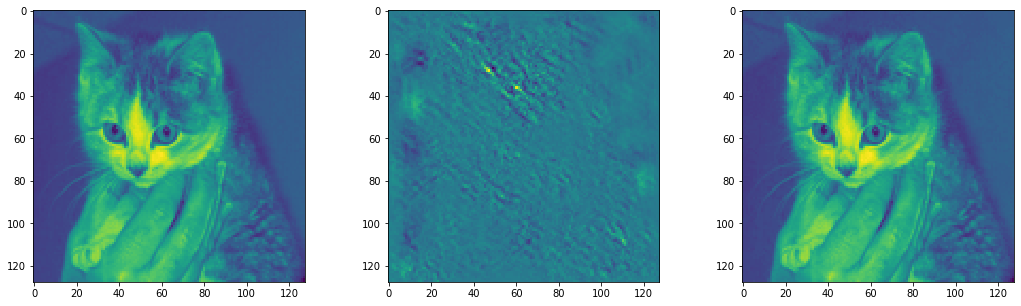

In [57]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.imshow(orig_image[0,:,:,0]) #testdata[imid,:,:,0]
plt.subplot(1,3,2)
plt.imshow(inp_grad)
plt.subplot(1,3,3)
plt.imshow(mod_image)

In [58]:
orig_op = sess.run(logits, feed_dict={images:orig_image})
mod_op = sess.run(logits, feed_dict={images:mod_image.reshape(-1, 128, 128,1)})
print(softmax(orig_op), softmax(mod_op))

[[3.8706473e-12 1.0000000e+00]] [[0.99706024 0.00293972]]


In [44]:
np.argmax(testlogits[:num_testfiles,:],1),sum(np.argmax(testlogits[:num_testfiles,:],1))

(array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 

In [75]:
np.argmax(testlabel[:num_testfiles,:],1), sum(np.argmax(testlabel[:num_testfiles,:],1))

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [76]:
np.argmax(testlogits[num_testfiles:,:],1),sum(np.argmax(testlogits[num_testfiles:,:],1))

(array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

In [77]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(testlabel,1), np.argmax(testlogits,1), normalize=True, sample_weight=None)

0.7695

In [140]:
image_data.shape, currloss, label_data

((32, 128, 128, 1), 69.68204164505005, array([[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]]))

In [22]:
rand_indices = np.arange(len(train_filenames))
np.random.shuffle(rand_indices)
image_data = imagesData[rand_indices[0:batch_size], :, :, 0].reshape(batch_size, IM_WIDTH,IM_HEIGHT,1)
label_data = imagesLabel[rand_indices[0:batch_size], :]

In [23]:
init = tf.global_variables_initializer()
#sess = tf.Session(config=tf.ConfigProto(
#      allow_soft_placement=True, log_device_placement=True))

with tf.Session(config=tf.ConfigProto(allow_soft_placement=False, log_device_placement=True)) as sess:
    sess.run(init)
    print("initialized...")
    print("now inferring...")
    for i in range(10):
        #cetropy = sess.run(cross_entropy_mean, feed_dict={images: image_data, labels: label_data})
        sftmaxlin = sess.run(logits, feed_dict={images: image_data})
        #currloss = sess.run(lossval, feed_dict={images: image_data, labels: label_data})
        print("infered ",i, " times")

initialized...
now inferring...
infered  0  times
infered  1  times
infered  2  times
infered  3  times
infered  4  times
infered  5  times
infered  6  times
infered  7  times
infered  8  times
infered  9  times


In [116]:
cetropy, sftmaxlin, currloss, label_data

(17.66, array([[-16.95  ,  -3.08  ],
        [-21.02  ,  -0.79  ],
        [-26.    ,   3.975 ],
        [-15.375 ,  -3.209 ],
        [-17.86  ,   3.904 ],
        [-23.02  ,   4.66  ],
        [-18.56  ,   0.801 ],
        [-20.14  ,   8.19  ],
        [-16.84  ,   0.6953],
        [-25.17  ,  -1.405 ],
        [-26.53  ,   2.072 ],
        [-20.81  ,  -0.9565],
        [-25.84  ,   6.684 ],
        [-16.58  ,   8.    ],
        [-24.16  ,   2.043 ],
        [-25.38  ,   3.857 ],
        [-27.77  ,   8.2   ],
        [-21.92  ,   3.719 ],
        [-18.36  ,  -3.045 ],
        [-26.14  ,   3.4   ],
        [-26.81  ,   1.618 ],
        [-19.3   ,  -2.805 ],
        [-15.51  ,   3.838 ],
        [-20.69  ,   4.332 ],
        [-20.4   ,   4.832 ],
        [-16.39  ,   2.703 ],
        [-25.14  ,   3.537 ],
        [-23.    ,   4.566 ],
        [-28.69  ,   4.027 ],
        [-25.56  ,   1.566 ],
        [-27.11  ,   6.406 ],
        [-26.72  ,   4.715 ]], dtype=float16), inf, array([[1.,

In [31]:
image_data.shape, label_data.shape

((32, 256, 256, 1), (32, 2))

In [ ]:
def set_inputs():
    """Construct distorted input for CIFAR training using the Reader ops.
    Returns:
    images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
    Raises:
    ValueError: If no data_dir
    """
    if not FLAGS.data_dir:
        raise ValueError('Please supply a data_dir')
    data_dir = os.path.join(FLAGS.data_dir, 'cifar-10-batches-bin')
    images, labels = retrieve_inputs(data_dir=data_dir,
                                     batch_size=FLAGS.batch_size)
    if FLAGS.use_fp16:
        images = tf.cast(images, tf.float16)
        labels = tf.cast(labels, tf.float16)
        
    if shuffle:
        images, label_batch = tf.train.shuffle_batch(
            [image, label],
            batch_size=batch_size,
            num_threads=num_preprocess_threads,
            capacity=min_queue_examples + 3 * batch_size,
            min_after_dequeue=min_queue_examples)
    else:
        images, label_batch = tf.train.batch(
            [image, label],
            batch_size=batch_size,
            num_threads=num_preprocess_threads,
            capacity=min_queue_examples + 3 * batch_size)

    # Display the training images in the visualizer.
    tf.summary.image('images', images)

    #return images, labels
    return images, tf.reshape(label_batch, [batch_size])

In [22]:
def train():
    with tf.Graph().as_default():
        global_step = tf.train.get_or_create_global_step()
    
        with tf.device('/cpu:0'):
            images, labels = set_inputs()

            # Build a Graph that computes the logits predictions from the
            # inference model.
            logits = inference_model(images)

            # Calculate loss.
            loss = loss(logits, labels)

            # Build a Graph that trains the model with one batch of examples and
            # updates the model parameters.
            train_op = train_network(loss, global_step)

            class _LoggerHook(tf.train.SessionRunHook):
                """Logs loss and runtime."""

                def begin(self):
                    self._step = -1
                    self._start_time = time.time()

                def before_run(self, run_context):
                    self._step += 1
                    return tf.train.SessionRunArgs(loss)  # Asks for loss value.

                def after_run(self, run_context, run_values):
                    if self._step % FLAGS.log_frequency == 0:
                        current_time = time.time()
                        duration = current_time - self._start_time
                        self._start_time = current_time

                        loss_value = run_values.results
                        examples_per_sec = FLAGS.log_frequency * FLAGS.batch_size / duration
                        sec_per_batch = float(duration / FLAGS.log_frequency)

                        format_str = ('%s: step %d, loss = %.2f (%.1f examples/sec; %.3f '
                                    'sec/batch)')
                        print (format_str % (datetime.now(), self._step, loss_value,
                                   examples_per_sec, sec_per_batch))

            with tf.train.MonitoredTrainingSession(
                checkpoint_dir=FLAGS.train_dir,
                hooks=[tf.train.StopAtStepHook(last_step=FLAGS.max_steps),
                       tf.train.NanTensorHook(loss),
                       _LoggerHook()],
                config=tf.ConfigProto(log_device_placement=FLAGS.log_device_placement)) as mon_sess:
                while not mon_sess.should_stop():
                    mon_sess.run(train_op)
